## Local Setup

If you prefer to work locally, see the following instructions for setting up Python in a virtual environment.
You can then ignore the instructions in "Colab Setup".

If you haven't yet, create a [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) environment using:
```
conda create --name rl_exercises
conda activate rl_exercises
```
Torch recommends installation using conda rather than pip, so run:
```
conda install pytorch cpuonly -c pytorch
```
If you have a CUDA-enabled GPU and would like to use it, visit [the installation page](https://pytorch.org/get-started/locally/) to see the options available for different CUDA versions.
The remaining dependencies can be installed with pip:
```
pip install ipykernel matplotlib numpy "gymnasium[classic-control, mujoco]" stable_baselines3
```

Even if you are running the Jupyter notebook locally, please run the code cells in **Colab Setup**, because they define some global variables required later.

## Colab Setup

Google Colab provides you with a temporary environment for python programming.
While this conveniently works on any platform and internally handles dependency issues and such, it also requires you to set up the environment from scratch every time.
The "Colab Setup" section below will be part of **every** exercise and contains utility that is needed before getting started.

There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window).
Any changes you make to the Jupyter notebook itself should be saved to your Google Drive.
We also save all recordings and logs in it by default so that you won't lose your work in the event of an instance timeout.
However, you will need to re-mount your Google Drive and re-install packages with every new instance.

In [2]:
"""Your work will be stored in a folder called `rl_ws24` by default to prevent Colab 
instance timeouts from deleting your edits.
We do this by mounting your google drive on the virtual machine created in this colab 
session. For this, you will likely need to sign in to your Google account and allow
access to your Google Drive files.
"""

%matplotlib inline

from pathlib import Path

try:
    from google.colab import drive

    drive.mount("/content/gdrive")
    COLAB = True
except ImportError:
    COLAB = False

# Create paths in your google drive
if COLAB:
    DATA_ROOT = Path("/content/gdrive/My Drive/rl_ws24")
    DATA_ROOT.mkdir(exist_ok=True)
else:
    DATA_ROOT = Path.cwd() / "rl_ws24"

# Install **python** packages
if COLAB:
    %pip install matplotlib numpy "gymnasium[mujoco, classic-control, other]" stable_baselines3 torch

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    import os
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
      with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

# Exercise 3: MDP Design

While the lecture focusses mainly on algorithmic developments, or the strengths and weaknesses of different methods, the environments those algorithms are applied to are usually taken for granted.
However, when trying to apply RL algorithms to a novel real-world problem, we often have many design choices to make that drastically affect the final outcome.
Designing a reward function, observations, actions, and termination conditions for a given task is [a famously frustrating and difficult problem](https://www.alexirpan.com/2018/02/14/rl-hard.html).
In this exercise, we will guide you through some of the pitfalls of applying RL in practice.


All homeworks are self-contained.
They can be completed in their respective notebooks.
Please fill in any missing code or answer any questions that are marked with `## TODO ##` statements.
Questions not marked with `## TODO ##` are self-test questions and do **not** need to be answered for points.
To edit and re-run code, you can simply edit and restart the code cells below.
When you are finished, you will need to submit the notebook as well as all saved figures (see exercises) as a zip file via Ilias.

We start by importing all the necessary python modules and defining some helper functions which you do not need to change.
Still, make sure you are aware of what they do.

In [8]:
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.core import Wrapper
from gymnasium.wrappers import TimeLimit
from IPython import display
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.logger import KVWriter, Logger
from stable_baselines3.common.monitor import Monitor

SEED = 3

# specify the path to save the recordings of this run to.
DATA_PATH = DATA_ROOT / "exercise_3" / time.strftime("%Y-%m-%d_%H-%M")


def save_figure(fig, save_name: str) -> None:
    """Saves a figure into your google drive folder or local directory"""
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    path = DATA_PATH / (save_name + ".png")
    fig.savefig(str(path))


class JupyterRenderEvalCallback(EvalCallback):
    """Renders evaluation trajectories in a matplotlib figure in a jupyter
    notebook.
    """

    def __init__(self, eval_env, *args, ax, image, n_episodes_to_render=1, **kwargs):
        super().__init__(eval_env, *args, **kwargs)
        self.ax = ax
        self.image = image
        self.n_episodes_to_render = n_episodes_to_render

    def _log_success_callback(self, locals_: dict, globals_: dict) -> None:
        """This function is called on every step of the evaluation, so we
        hijack it for rendering the policy.
        """
        # call the parent method because it's responsible for logging success
        super()._log_success_callback(locals_, globals_)

        # we use the 0th element here because there is only 1 eval env
        if locals_["episode_counts"][0] < self.n_episodes_to_render:
            env = locals_["env"]
            rendering = env.render()
            display.clear_output(wait=True)
            self.image.set_data(rendering)
            plt.sca(self.ax)
            display.display(plt.gcf())

    def set_plt_refs(self, ax, image):
        self.ax = ax
        self.image = image


class PlotFormat(KVWriter):
    """Logs values by plotting them in a matplotlib figure in a jupyter
    notebook.
    """

    def __init__(self, axs: list, lines: dict):
        self.axs = axs
        self.lines = lines
        self.timesteps = []
        self.data = defaultdict(list)

    def write(
        self,
        key_values: dict,
        key_excluded={},
        step: int = 0,
    ) -> None:
        if any(key in key_values for key in self.lines):
            assert all(key in key_values for key in self.lines)
            self.timesteps.append(step)
            display.clear_output(wait=True)
            for key, line in self.lines.items():
                self.data[key].append(key_values[key])
                line.set_data(self.timesteps, self.data[key])
            for ax in self.axs:
                ax.relim()  # Recompute the data limits
                ax.autoscale_view()  # Autoscale to fit new data
            plt.sca(self.axs[0])
            display.display(plt.gcf())

    def set_plt_refs(self, axs: list, lines: dict):
        self.axs = axs
        self.lines = lines

    def clear(self):
        self.timesteps.clear()
        self.data.clear()


def create_figure(figsize: tuple[int, int], n_steps: int) -> tuple:
    fig, axs = plt.subplots(1, 3, figsize=tuple(figsize))
    axs = {"render": axs[0], "return": axs[1], "success": axs[2]}

    # remove tickmarks and axis labels
    axs["render"].set_axis_off()

    axs["return"].set(title="Mean Return", xlabel="Environment Steps")
    axs["return"].set_xlim(0, n_steps)

    axs["success"].set(
        title="Success Rate", xlabel="Environment Steps", ylabel="Success"
    )
    axs["success"].set_xlim(0, n_steps)
    axs["success"].set_ylim(0, 1)

    fig.tight_layout()

    return fig, axs

## Question 1: Termination vs. Truncation (2 points)

First we will look at a common mistake that can subtly break many RL algorithms.
Adding to the difficulty is that many algorithms will usually still learn, they will just perform slightly worse.
We demonstrate this mistake on SAC, because it tends to be the most sensitive to it.
Understanding this problem will help you learn how to visualize an MDP from the agent's "perspective".

The gymnasium `step` function returns two booleans that both indicate the end of a trajectory: `terminated` and `truncated`.

`terminated` is a feature of the MDP itself.
It describes when a terminal state of the MDP has been reached, and no more future rewards are possible.
Intuitively, we can imagine that the agent has either "lost" or succeeded, and the "game" is over.

<center>
<img src="https://media1.tenor.com/m/Kzd7ERPff_gAAAAC/game-over-game.gif" width="300"/>
</center>

`truncated` means that a time limit has been reached, but the MDP is not necessarily in a terminal state.
The time limit is usually added as a part of training to regularly "teleport" the agent back to the starting state.
This prevents too much useless data from being generated, especially at the start of training, where the agent wanders somewhere far from the optimal trajectory and can't find its way back.
However, the agent could have continued collecting rewards if we had let it.
Future rewards would have been possible.

\## TODO ##

Write down the equation where the terminated and/or truncated signal are used as part of learning.


$Q(s,a) \leftarrow r(s,a) + \gamma \cdot (1 - \text{terminated}) \cdot Q(s', a')$  
        terminated < 1

\## END ##


The code cell below contains a script for training a policy to solve Pendulum with SAC using the [Stable Baselines 3](https://stable-baselines3.readthedocs.io) framework.
We define a success metric using an [environment wrapper](https://gymnasium.farama.org/api/wrappers/) that writes a boolean into the `info` dict returned by the step function when a trajectory ends.
Of course, Stable Baselines 3 does handle truncation and termination correctly, but we can simulate the bug we are interested in by modifying the environment itself to return incorrect values.
This is done by adding an environment wrapper that incorrectly treats timeouts as terminations and modifies the results of the environment's `step` function.
Fill in the missing code in the `step` function of the `TruncateAsTerminateWrapper`.
Then, run the code cell to see the effect that this error can have on SAC.

In the figure below, you can watch the policy evaluations in the leftmost subplot.
Only the first evaluation trajectory is shown, but the metrics on the right are averaged over 20 trajectories that run without rendering.
The other plots show learning curves for mean return (sum of rewards) and success for each variant.

Warning! You should never attempt to learn about Reinforcement Learning by reading the source code of Stable Baselines 3.
Exposure to the source code of SB3, even for short periods, has been shown to cause long-lasting health effects.
To actually learn about RL, we recommend [cleanrl](https://cleanrl.dev).

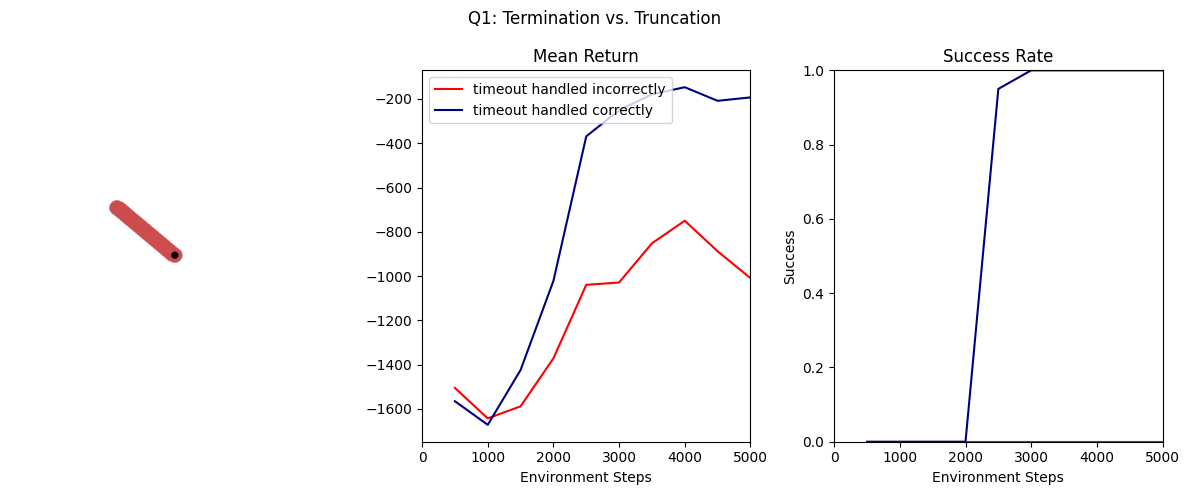

In [12]:
class PendulumSuccessWrapper(Wrapper):
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        if truncated or terminated:
            x, y, omega = obs
            theta = np.arctan2(y, x) * 180 / np.pi
            info["is_success"] = abs(theta) < 10 and abs(omega) < 1e-2

        return obs, reward, terminated, truncated, info


class TruncateAsTerminateWrapper(Wrapper):
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        ## TODO ##
        if truncated:
         terminated = True
        ## END ##
        return obs, reward, terminated, truncated, info


def make_pendulum(max_episode_steps=None, incorrect=False, **kwargs):
    env = gym.make("Pendulum-v1", max_episode_steps=max_episode_steps, **kwargs)
    env = PendulumSuccessWrapper(env)
    if incorrect:
        env = TruncateAsTerminateWrapper(env)
    return env


SEED = 3
N_STEPS = 5000
LOG_FREQ = EVAL_FREQ = 500
RENDER = False


rng = np.random.default_rng(SEED)
sb3_seed = int(rng.integers(2**32))
eval_env_seed = int(rng.integers(2**32))

# we always evaluate on the original environment, although we might train
# on an improved version of the environment
eval_env = make_pendulum(render_mode="rgb_array")
eval_env.reset()  # need to reset before rendering
log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q1: Termination vs. Truncation")
fig.tight_layout()
image = axs["render"].imshow(eval_env.render())
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("timeout handled incorrectly", True, "red"),
    ("timeout handled correctly", False, "navy"),
]
for label, incorrect, color in VARIANTS:

    env = make_pendulum(incorrect=incorrect, max_episode_steps=50)

    # we don't change eval_env, because we test on the original problem
    eval_env.reset(seed=eval_env_seed)
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1 if RENDER else 0,
        ax=axs["render"],
        image=image,
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    model = SAC(
        "MlpPolicy",
        env,
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )

# # clear duplicate plot
# display.clear_output()

save_figure(fig, "Q1_timeouts")

### Self-Test Questions (optional)

In this question, we use SAC to demonstrate the loss in performance associated with incorrectly handling timeouts.
Although this mistake should affect almost all algorithms (anything that learns a Q or value function), empirically, SAC is the most sensitive to it.
Can you explain why?

We set the timeout for the training environment to 50 steps but leave that of the evaluation environment at 200 steps.
Why do each of these decisions help to amplify the effect we are trying to show here?

### Episodic vs. Infinite-Horizon Tasks

There are two fundamental types of tasks in RL, although there is not really a strict definition for what they are.
Their main distinguihsing feature is the `termination` condition (recall that almost all tasks have a truncation condition when a timeout is reached).

Episodic tasks (also called finite-horizon tasks) are usually those where the goal is to change in the environment in some way or reach some state, after which the task is over.
Examples may include Go, chess, navigation, pick-and-place, and many others.
Infinite-horizon tasks (also called continuing tasks) usually involve trying to reach a goal state which is typically unstable and then staying there despite disturbances.
They may also involve maximizing some utility in a way that cannot be easily divided or bounded into episodes.
Examples may include plant control, walking or running, balancing things, trading stocks, and many others.

The difficulty is that many tasks can be formulated as either episodic or infinite-horizon, and it is not immediately clear which formulation is easier for an algorithm learn.
Reward design is often quite different depending on whether an episodic or an infinite-horizon formulation is chosen.

<center>
<img src="https://github.com/mikelma/craftium/raw/main/craftium-docs/imgs/env_speleo.gif" width="300"/>
</center>

For example, would you say this task is episodic or infinite-horizon?

## Question 2: Episodic Environments (3 points)

Let's start with a modified version of an episodic environment you are probably already familiar with, [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).
However, this time the environment is deterministic (no slippery surfaces!), and instead we are simply trying to navigate to the goal without colliding with any obstacles (the ice patches).
This environment will act as a stand-in for a more complex, 3D navigation problem.

<center>
<img src="https://gymnasium.farama.org/_images/frozen_lake.gif" width="200"/>
</center>

A central theme of this exercise is the discrepancy between rewards and success.
Success is often easy to define, and is a sparse metric that indicates if the desired state was reached at the end of a trajectory.
Ideally, we could set our reward function to be our success metric:

\begin{equation}
    r(s,a,s') = \mathbf{I}(s' = s_{\mathrm{goal}})
\end{equation}

Unfortunately, this is usually too sparse for most real-world problems.
If the agent does not find the goal state through random chance, it will never even figure out what the goal state is!
Sparse rewards can work in 2D, but are usually impossible in 3D.
Because there are so many more possible states in 3D, we need to give our agent shaped rewards so it feels a constant "pull" in the direction we want it to go.

Therefore, we modify the rewards of FrozenLake to be dense (or shaped) rewards.
Read the code for the `step` function yourself and verify that it makes sense.
The success metric is simply whether the agent is in the goal state at the end of the trajectory.

In [13]:
from gymnasium.envs.toy_text.frozen_lake import DOWN, LEFT, RIGHT, UP, FrozenLakeEnv


class ShapedRewardsFrozenLakeEnv(FrozenLakeEnv):
    """FrozenLake with dense rewards for navigating to goal."""

    def __init__(self, *args, is_slippery=False, **kwargs):
        super().__init__(*args, is_slippery=is_slippery, **kwargs)

        nrow, ncol = self.nrow, self.ncol
        desc = self.desc
        self.goal = np.argmax(self.desc.flatten() == b"G")
        self.goal_row, self.goal_col = np.divmod(self.goal, ncol)

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            new_row, new_col = inc(row, col, action)
            new_state = to_s(new_row, new_col)
            new_letter = desc[new_row, new_col]
            terminated = bytes(new_letter) in b"GH"
            reward = float(new_letter == b"G")
            return new_state, reward, terminated

        # modify MDP transitions so that agent can exit hole states
        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    li.clear()
                    if is_slippery:
                        for b in [(a - 1) % 4, a, (a + 1) % 4]:
                            li.append(
                                (1.0 / 3.0, *update_probability_matrix(row, col, b))
                            )
                    else:
                        li.append((1.0, *update_probability_matrix(row, col, a)))

    def _get_square_type(self):
        """Returns the letter code (S, F, H, or G) for the current state.
        S: Start
        F: normal cell
        H: hole (i.e. ice patch)
        G: Goal
        """
        return self.desc.flatten()[self.s]

    def step(self, a):
        obs, reward, terminated, truncated, info = super().step(a)

        # modify rewards to be the negative distance to goal
        row, col = divmod(obs, self.ncol)
        distance = np.linalg.norm([self.goal_row - row, self.goal_col - col], ord=1)
        reward = -distance / 10

        # add rewards for reaching goal and hitting obstacle
        square = self._get_square_type()
        if square == b"G":
            reward += 1
        elif square == b"H":
            reward += -1

        return obs, reward, terminated, truncated, info


class FrozenLakeSuccessWrapper(Wrapper):
    """Adds a success metric to FrozenLake. A trajectory is successful if it
    ends on the goal square.
    """

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        if truncated or terminated:
            info["is_success"] = obs == self.env.unwrapped.goal

        return obs, reward, terminated, truncated, info

Next we define a training pipeline for PPO on our `ShapedRewardsFrozenLakeEnv` environment.
Since this is a tabular environment, we define the value function and policy to be look-up tables (no hidden layers or non-linearities).

Run the cell to train the policy.
Don't worry if it looks like your agent isn't exploring.
Only the deterministic evaluation trajectories are rendered, while the stochastic exploration steps are never shown.

Notice that the returns seem to increase and then converge, but the success rate is always 0..
Looking at the rendering, the policy seems to think it's best to throw itself into the nearest ice patch it can find.
Can you think of why?

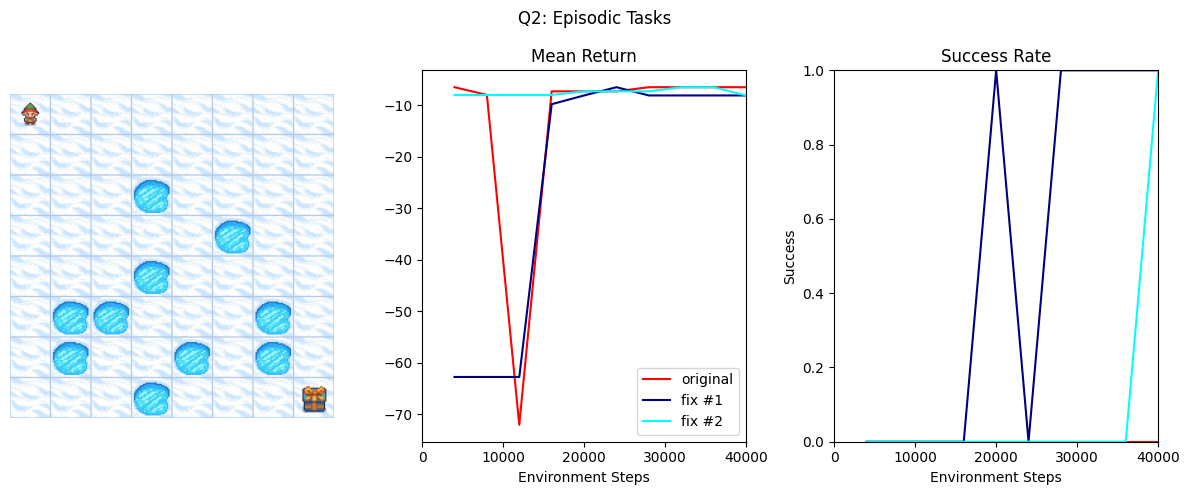

In [16]:
def make_frozenlake(max_episode_steps=100, fix_no=None, **kwargs):
    if fix_no is not None:
        EnvCls = FixedFrozenLakeEnv
        kwargs["fix_no"] = fix_no
    else:
        EnvCls = ShapedRewardsFrozenLakeEnv
    env = EnvCls(**kwargs)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    env = FrozenLakeSuccessWrapper(env)
    env = Monitor(env)
    return env


DISCOUNT = 0.99  # default discount value for PPO
N_STEPS = 40000
LOG_FREQ = EVAL_FREQ = 4000
MAP_NAME = "8x8"
RENDER = True


rng = np.random.default_rng(SEED)
sb3_seed = int(rng.integers(2**32))
eval_env_seed = int(rng.integers(2**32))

# we always evaluate on the original environment, although we might train
# on an improved version of the environment
eval_env = make_frozenlake(map_name=MAP_NAME, render_mode="rgb_array")
eval_env.reset()  # need to reset before rendering
log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q2: Episodic Tasks")
fig.tight_layout()
image = axs["render"].imshow(eval_env.render())
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])
display.display(plt.gcf())

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("original", None, "red"),
     ("fix #1", 1, "navy"),
     ("fix #2", 2, "aqua"),
]
for label, fix_no, color in VARIANTS:

    env = make_frozenlake(map_name=MAP_NAME, fix_no=fix_no)

    # we don't change eval_env, because we test on the original problem
    eval_env.reset(seed=eval_env_seed)
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1 if RENDER else 0,
        ax=axs["render"],
        image=image,
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    model = PPO(
        "MlpPolicy",
        env,
        gamma=DISCOUNT,
        # value function and policy with no hidden layers (i.e. lookup tables)
        policy_kwargs=dict(net_arch=dict(pi=[], vf=[])),
        device="cpu",
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )

# # clear duplicate plot
# display.clear_output()

save_figure(fig, "Q2_episodic")

In fact, PPO is indeed learning the optimal policy for the MDP we have defined.
The issue is that the MDP we defined does not accurately reflect the task (the success metric) we intended.

There are several possible fixes to this problem, either by adjusting the rewards or the termination condition. 
Implement any two fixes you can think of in the code cell below, then run it.
Afterwards, go to the previous code cell and uncomment all entries in the `VARIANTS` list, then run the cell.
This will produce a single plot that compares your two solutions to the performance of the original environment.

Try to avoid adding rewards with specific values, or rewards that might be too high.
Both of these cases may require you to retune your algorithm, and are not necessarily generalizable to more complex problems in 3D.

To reduce training time while trying out new ideas, you can increase the `EVAL_INTERVAL`, or just set `RENDER` to `False`, which disables rendering the policy during evaluation.
However, remember that visualizing the policy rollouts is essential for gaining insight into why policy learning might be failing.
You can also change `MAP_NAME` from `8x8` to `4x4` to prototype ideas on a smaller version of the environment.

In [14]:
class FixedFrozenLakeEnv(ShapedRewardsFrozenLakeEnv):
    def __init__(self, *args, fix_no=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.fix_no = fix_no

    def step(self, a):
        obs, reward, terminated, truncated, info = super().step(a)

        # modify rewards to be the negative distance to goal
        row, col = divmod(obs, self.ncol)
        distance = np.linalg.norm([self.goal_row - row, self.goal_col - col], ord=1)
        reward = -distance / 10

        # add rewards for reaching goal and hitting obstacle
        square = self._get_square_type()
        if square == b"G":
            reward += 1
        elif square == b"H":
            reward += -1

        if self.fix_no == 1:
            ## TODO ##
            # Fix 1: Not terminating when entering a cave
            if square == b"H":
                terminated = False
            ## END ##
        elif self.fix_no == 2:
            ## TODO ##
            if square == b"H":
                risk_probability = 0.3 
                # Terminate the round with a certain probability
                if np.random.rand() < risk_probability:
                    terminated = True
                else:
                    terminated = False
                # Additional penalty for staying in the danger zone
                reward += -0.5  # Add extra cost
            
            
            # # Fix 2: Add more higher rewards when reaching the target
            # if square == b"G": （doesn't work）
            #     reward += 2
            ## END ##
        else:
            raise ValueError

        return obs, reward, terminated, truncated, info

### Self-Test Questions (optional)

If you have implemented a solution that just retunes the reward values, does your solution still work for different values of $\gamma$ (`DISCOUNT`)?
In particular, try $\gamma=1.0$.
This value of discount is common for episodic tasks in practice, such as robotic manipulation or navigation tasks.

How does PPO respond to rewards at different scales?
For example, what happens if all rewards are increased by a factor of 10?
Why might this be happening?

## Question 3: Infinite-Horizon Environments (4 points)

In this question, we will look at two common infinite-horizon environments.

[Inverted Pendulum](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/) is a classic control problem that involves maintaining a vertical pole in an unstable state.
It is similar to the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment, but the actions are continuous rather than discrete.

[Reacher](https://gymnasium.farama.org/environments/mujoco/reacher/) is simple continuous problem which involves moving the fingertip of a 2-joint robot to a target position.
It's infinite-horizon because it never terminates.
The rewards for Reacher are the negative distance to the target position, plus a small control penalty for the norm of the actions applied.

<center>
<img src="https://gymnasium.farama.org/_images/inverted_pendulum.gif" width="300"/>
<img src="https://gymnasium.farama.org/_images/reacher.gif" width="300"/>
</center>

### Question 3a: Infinite-Horizon Tasks as Episodic Tasks (1 point)

Sometimes, it is possible to reformulate an infinite-horizon task as an episodic task while (mostly) preserving the desired behaviour.
Let's start by considering what happens if we reformulate Reacher as an episodic task.
Episodic Reacher should end if the fingertip is within a threshold of the target position.
Fill in a termination condition in the code cell below, then run the cell to compare the infinite-horizon and episodic variants of Reacher.

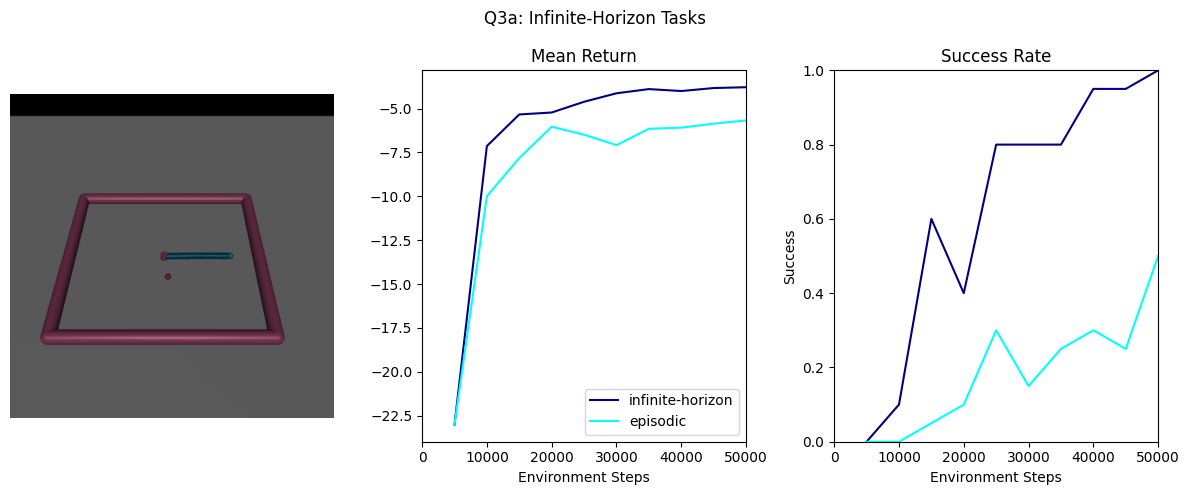

New best mean reward!


In [18]:
from gymnasium.envs.mujoco.reacher_v5 import ReacherEnv

TARGET_THRESHOLD = 0.05
MAX_VELOCITY = 1.0


class EpisodicReacherWrapper(Wrapper):
    def step(self, action):
        observation, reward, terminated, truncated, info = super().step(action)

        ## TODO ##
        distance_to_target = np.linalg.norm(observation[8:10])
        if distance_to_target < TARGET_THRESHOLD:
            terminated = True
        ## END ##

        return observation, reward, terminated, truncated, info


class ReacherSuccessWrapper(Wrapper):
    """Adds a success metric to Reacher. A trajectory is successful if it
    ends near the target position and fingertip is not moving too fast.
    """

    def step(self, action):
        observation, reward, terminated, truncated, info = super().step(action)

        if truncated or terminated:
            target_vector = observation[8:10]
            ang_velocity = observation[6:8]
            success = (
                np.linalg.norm(target_vector) < TARGET_THRESHOLD
                and (np.abs(ang_velocity) < MAX_VELOCITY).all()
            )
            info["is_success"] = success

        return observation, reward, terminated, truncated, info


def make_reacher(max_episode_steps=50, episodic=False, **kwargs):
    env = ReacherEnv(**kwargs)
    if episodic:
        env = EpisodicReacherWrapper(env)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    env = ReacherSuccessWrapper(env)
    env = Monitor(env)
    return env


N_STEPS = 50000
LOG_FREQ = EVAL_FREQ = 5000
RENDER = True

rng = np.random.default_rng(SEED)
sb3_seed = int(rng.integers(2**32))
eval_env_seed = int(rng.integers(2**32))

# we always evaluate on the original environment, although we might train
# on an improved version of the environment
eval_env = make_reacher(render_mode="rgb_array")
eval_env.reset()  # need to reset before rendering
log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q3a: Infinite-Horizon Tasks")
fig.tight_layout()
image = axs["render"].imshow(eval_env.render())
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("infinite-horizon", False, "navy"),
    ("episodic", True, "aqua"),
]
for label, episodic, color in VARIANTS:

    env = make_reacher(episodic=episodic)

    # we don't change eval_env, because we test on the original problem
    eval_env.reset(seed=eval_env_seed)
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1 if RENDER else 0,
        ax=axs["render"],
        image=image,
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=7.3e-4,
        batch_size=256,
        gamma=0.98,
        tau=0.02,
        train_freq=8,
        gradient_steps=8,
        learning_starts=5000,
        policy_kwargs=dict(log_std_init=-3, net_arch=[256, 256]),
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )

# # clear duplicate plot
# display.clear_output()

save_figure(fig, "Q3a_infinite-horizon")

If you implemented the modification correctly, you should see that the episodic environment results in a similar mean return but a much lower success rate.
Although neither environment provides a reward signal directly the success criteria (distance threshold and maximum angular velocity), the agent trained on the infinite-horizon environment learns to fulfill both of them implicitly.
In contrast, the agent trained on the episodic environment has no incentive to learn to stop the finger at the target position, since it maximizes the return (during training) by reaching the target position as quickly as possible.
Note that both policies are evaluated on the infinite-horizon formulation of the environment.

### Question 3b: Bounded Returns (2 points)

[Inverted Pendulum](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/) is one of the simplest toy problems used in RL.
Unfortunately, the default reward function for Inverted Pendulum is not great.
For each step that the pole is upright (i.e. for each transition of the trajectory except the last), the reward is $1.0$.
For the last transition, the reward is $0.0$.

\begin{equation}
    r(s,a,s') = \mathbf{I}(s' \notin \{s_{\mathrm{failed}}\})
\end{equation}

This might sound like a suitable reward function, as it incentivizes the right thing, namely longer trajectories.
For such an **infinite-horizon task**, however, it can be improved upon.

\## TODO ##

Explain why the standard reward function for Inverted Pendulum is sub-optimal.
In order to understand why, consider the limiting case as discount $\gamma \rightarrow 1.0$.

$V(s) = \mathbb{E}\Big[\sum_{t=0}^\infty \gamma^t \cdot r_t\Big]$  
For the inverted pendulum, if the agent can keep the pole upright indefinitely, then at each step $r_t = 1.0$  

$V(s) = \sum_{t=0}^\infty \gamma^t \cdot 1 = \frac{1}{1-\gamma}$  
When $ \gamma$ tends 1, the denominator $ 1 - \gamma $ in the above formula tends 0, making V(s) tends infinity. This will cause the value of the state to become very large, tending to infinity. And then result in numerical instability, and high variance. This leads problems with gradient calculation, like exploding gradient.


\## END ##

Luckily, there is a very simple reward transformation that already improves learning.
This transformation is completely independent of the state and the action; the new reward is only a function of the old reward.
Implement this reward transformation in the wrapper below, and then compare the transformed rewards to the original rewards by running the cell.

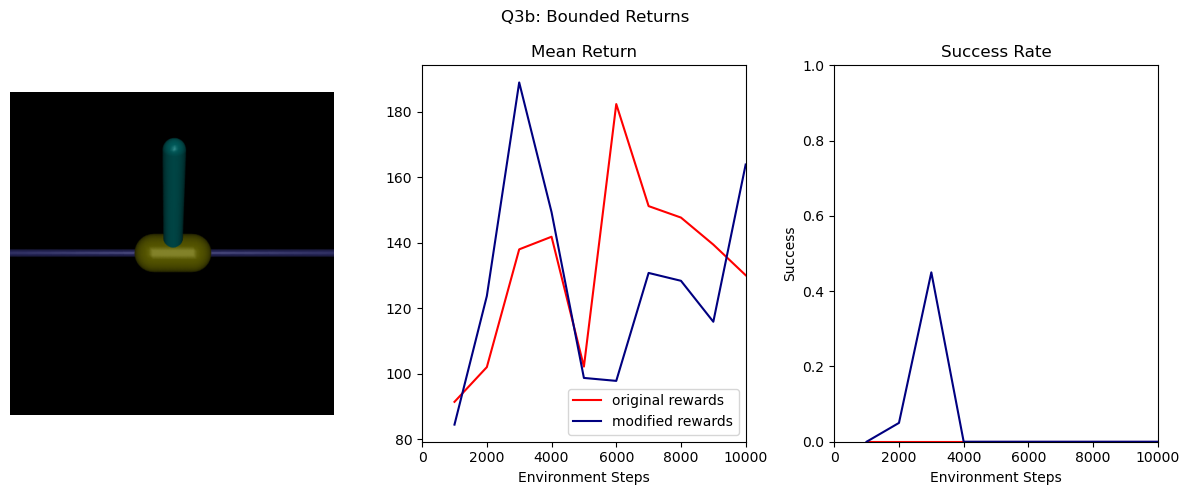

In [22]:
from gymnasium.envs.mujoco.inverted_pendulum_v5 import InvertedPendulumEnv
from gymnasium.wrappers import TransformReward


def inverted_pendulum_reward_transform(reward: float) -> float:
    ## TODO ##
    
    gamma = 0.99  # Discount factor for decaying rewards
    reward = reward * gamma
    
    
    ## END ##
    return reward


class InvertedPendulumSuccessWrapper(Wrapper):
    """Adds a success metric to InvertedPendulum. Since there is already a failure
    condition, we just have to make sure the trajectory timed out instead.
    """

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        if truncated or terminated:
            info["is_success"] = truncated

        return obs, reward, terminated, truncated, info


def make_inverted_pendulum(max_episode_steps=200, fix_rewards=False, **kwargs):
    env = InvertedPendulumEnv(**kwargs)
    if fix_rewards:
        env = TransformReward(env, inverted_pendulum_reward_transform)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    env = InvertedPendulumSuccessWrapper(env)
    env = Monitor(env)
    return env


N_STEPS = 10000
LOG_FREQ = EVAL_FREQ = 1000
RENDER = True


rng = np.random.default_rng(SEED)
sb3_seed = int(rng.integers(2**32))
eval_env_seed = int(rng.integers(2**32))

# we always evaluate on the original environment, although we might train
# on an improved version of the environment
eval_env = make_inverted_pendulum(render_mode="rgb_array")
eval_env.reset()  # need to reset before rendering
log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q3b: Bounded Returns")
fig.tight_layout()
image = axs["render"].imshow(eval_env.render())
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("original rewards", False, "red"),
    ("modified rewards", True, "navy"),
]
for label, fix_rewards, color in VARIANTS:

    env = make_inverted_pendulum(fix_rewards=fix_rewards)

    # we don't change eval_env, because we test on the original problem
    eval_env.reset(seed=eval_env_seed)
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1 if RENDER else 0,
        ax=axs["render"],
        image=image,
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    model = SAC(
        "MlpPolicy",
        env,
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )

# clear duplicate plot
display.clear_output()

save_figure(fig, "Q3b_bounded_returns")

### Self-Test Questions (optional)

In this question, we used SAC to demonstrate the effect that these two (equivalent) reward functions can have.
Empirically, PPO is less affected by the choice between these two reward functions.
Can you explain why?

### Question 3c: Discount and the Pull of Time (1 point)

In the previous question, we considered the limiting case when $\gamma \rightarrow 1.0$ to gain insight into the reward function.
This limiting case is unfavourable for the original reward function of Inverted Pendulum, but setting $\gamma = 1.0$ is actually suboptimal for most infinite-horizon tasks.
Even the "fixed" reward function suffers under this condition.

Although the discount $\gamma$ is technically part of the MDP definition, most frameworks treat it as a hyperparameter of the algorithm.
In the code cell below, in the for loop, set `gamma` in the learning pipeline according to the value of the loop variable `gamma`.
Then run the code cell to compare the effect of these two values of discount.

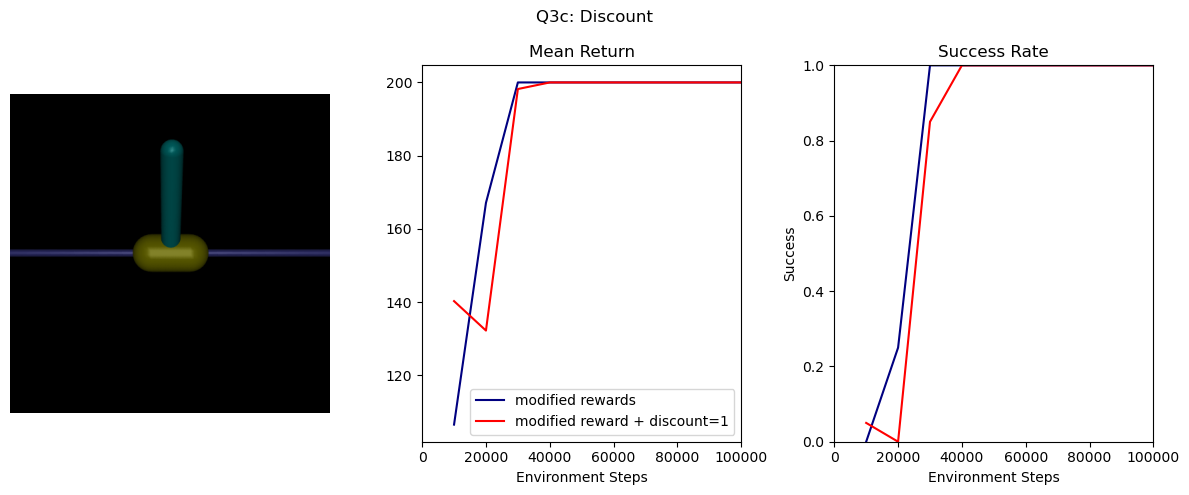

In [33]:
N_STEPS = 100000
LOG_FREQ = EVAL_FREQ = 10000
RENDER = True


env = make_inverted_pendulum(fix_rewards=True)
# we always evaluate on the original environment, although we might train
# on an improved version of the environment
eval_env = make_inverted_pendulum(render_mode="rgb_array")
log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q3c: Discount")
fig.tight_layout()
image = axs["render"].imshow(eval_env.render())
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("modified rewards", 0.99, "navy"),
    ("modified reward + discount=1", 1.0, "red"),
]
for label, gamma, color in VARIANTS:

    eval_env.reset(seed=eval_env_seed)
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1 if RENDER else 0,
        ax=axs["render"],
        image=image,
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    ## TODO ##
    model = PPO(
        "MlpPolicy",
        env,
        gamma=gamma,
        gae_lambda=1.0,  # use monte-carlo returns
        device="cpu",
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )
    ## END ##

# clear duplicate plot
display.clear_output()

save_figure(fig, "Q3c_discount")

### Self-Test Questions (optional)

In this question, we used PPO to demonstrate the effect of the discount factor.
Algorithms that rely on Q-Learning, such as SAC and DQN, are less affected by the choice of discount factor.
Can you explain why?

We set a value called `gae_lambda` ($\lambda_{GAE}$) to $1.0$ in this question.
What does this hyperparameter do?
Why does setting it to $1.0$ make it easier to demonstrate the effect of the discount factor $\gamma$?

## Question 4: Multi-Phase Tasks (6 points)

In the real world, the vast majority of interesting tasks can be categorized as multi-phase tasks.
A multi-phase task is any task where the objective or reward function shifts during the trajectory.
For example, think of picking up a cup and placing it somewhere else, or inserting a key into a lock and then turning it.
The first phase of the desired motion probably requires a different shaped reward than the second phase.
Formally, we can define a reward function for the task that depends on the phase, but colloquially we usually speak about separate reward functions for each phase.
The phase may be observable or it may need to be inferred from the observable features of the environment.

Multi-phase MDP design is hard, with many pitfalls.
We have implemented a multi-phase version of the Reacher environment, in which if the finger is within a threshold of the target, a new target is sampled.
The finger must not be moving too quickly for the next phase to be triggered.
After the target is reached in the second phase, the task is successful.

Unfortunately, the algorithm (SAC with well-tuned hyperparameters) cannot learn a successful policy from our naive environment.
Find a way to modify the environment given in `FixedMultiPhaseReacherEnv` so that the algorithm learns to solve the task.
You can modify the observations or anything in the `step` function.
The `phase_success` variable is pre-computed for you in a way that is still correct even if the observations change, and probably doesn't need to be changed.

Consider the task and its rewards from the agent's perspective throughout the desired trajectory.
Again, try to avoid adding rewards with specific values, or rewards that might be too high.
Both of these cases may require you to retune your algorithm, and are not necessarily generalizable to more complex problems in 3D.

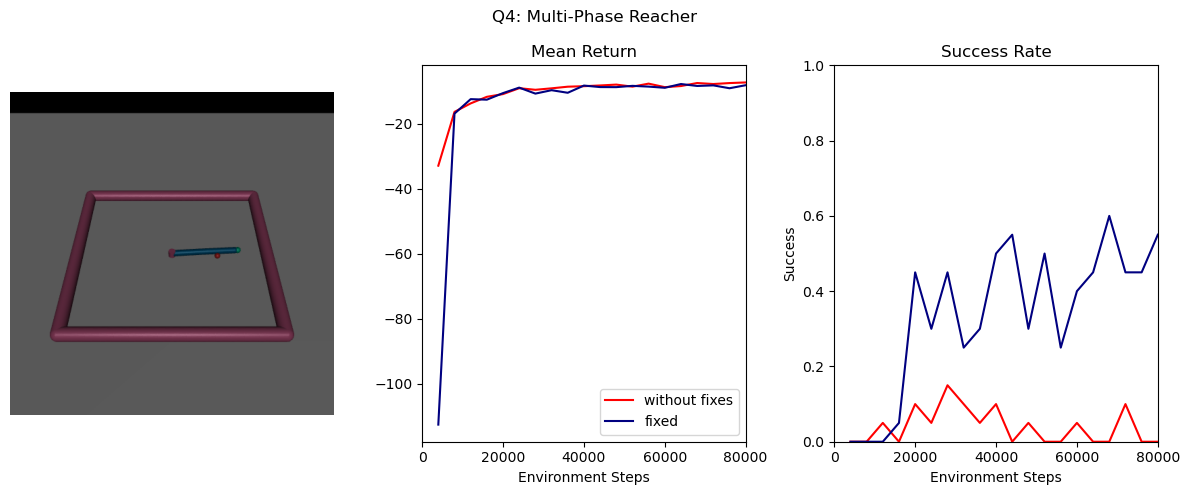

In [36]:
import gymnasium.spaces as spaces
from gymnasium.envs.mujoco.reacher_v5 import ReacherEnv

TARGET_THRESHOLD = 0.05
MAX_VELOCITY = 1.0


class MultiPhaseReacherEnv(ReacherEnv):
    def __init__(self, *args, n_phases=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_phases = n_phases  # Two phases for two targets

    def step(self, action):
        observation, reward, terminated, truncated, info = super().step(action)

        # Check if the current target is reached and the arm is not moving too fast
        target_vector = observation[8:10]
        ang_velocity = observation[6:8]
        phase_success = (
            np.linalg.norm(target_vector) < TARGET_THRESHOLD
            and (np.abs(ang_velocity) < MAX_VELOCITY).all()
        )

        if phase_success and self.current_phase < (self.n_phases - 1):
            # increment phase
            self.current_phase += 1

            # set new target and get new observation, since it depends on target
            self._set_new_target()
            observation = self._get_obs()

        return observation, reward, terminated, truncated, info

    def reset_model(self):
        self.current_phase = 0
        return super().reset_model()

    def _set_new_target(self):
        while True:
            target = self.np_random.uniform(low=-0.2, high=0.2, size=2)
            if np.linalg.norm(target) < 0.2:
                break

        qpos = self.data.qpos.copy()
        qpos[-2:] = target
        self.set_state(qpos, self.data.qvel)


class MultiPhaseReacherSuccessWrapper(Wrapper):
    """Adds a success metric to Reacher. A trajectory is successful if it
    ends near the target position and fingertip is not moving too fast.
    """

    def step(self, action):
        observation, reward, terminated, truncated, info = super().step(action)

        if truncated or terminated:
            # ensure we get unmodified observation of parent environment
            base_obs = ReacherEnv._get_obs(self.env.unwrapped)
            target_vector = base_obs[8:10]
            ang_velocity = base_obs[6:8]
            phase = self.env.unwrapped.current_phase
            success = (
                np.linalg.norm(target_vector) < TARGET_THRESHOLD
                and (np.abs(ang_velocity) < MAX_VELOCITY).all()
                and phase == (self.env.unwrapped.n_phases - 1)
            )
            info["is_success"] = success

        return observation, reward, terminated, truncated, info


class FixedMultiPhaseReacherEnv(MultiPhaseReacherEnv):
    ## TODO ##
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Update observation space to include current phase
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(11,), dtype=np.float64
        )

    def step(self, action):
        observation, reward, terminated, truncated, info = super().step(action)

        # Check if the current target is reached and the arm is not moving too fast
        # ensure we get unmodified observation of parent environment
        base_obs = ReacherEnv._get_obs(self)
        target_vector = base_obs[8:10]
        ang_velocity = base_obs[6:8]
        phase_success = (
            np.linalg.norm(target_vector) < TARGET_THRESHOLD
            and (np.abs(ang_velocity) < MAX_VELOCITY).all()
        )

        if phase_success and self.current_phase < (self.n_phases - 1):
            # increment phase
            self.current_phase += 1

            # set new target and get new observation, since it depends on target
            self._set_new_target()
            observation = self._get_obs()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        # Get the parent observation
        observation = super()._get_obs()

        # Append the current phase as part of the observation
        current_phase_obs = np.array([self.current_phase], dtype=np.float64)

        # Combine the original observation with the current phase
        extended_observation = np.concatenate((observation, current_phase_obs))

        return extended_observation

    ## END ##


def make_multiphasereacher(
    n_phases=2, with_fixes=False, max_episode_steps=100, **kwargs
):
    EnvCls = FixedMultiPhaseReacherEnv if with_fixes else MultiPhaseReacherEnv
    env = EnvCls(n_phases=n_phases, **kwargs)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    env = MultiPhaseReacherSuccessWrapper(env)
    env = Monitor(env)
    return env


N_STEPS = 80_000
LOG_FREQ = EVAL_FREQ = 4000
RENDER = True

rng = np.random.default_rng(SEED)
sb3_seed = int(rng.integers(2**32))
eval_env_seed = int(rng.integers(2**32))

fig, axs = create_figure(figsize=(12, 5), n_steps=N_STEPS)
fig.suptitle(f"Q4: Multi-Phase Reacher")
fig.tight_layout()
plotter = PlotFormat(axs=[], lines={})
logger = Logger(folder=None, output_formats=[plotter])

# NOTE: Comment out any variants you don't want to test
VARIANTS = [
    ("without fixes", False, "red"),
    ("fixed", True, "navy"),
]
for label, with_fixes, color in VARIANTS:

    env = make_multiphasereacher(with_fixes=with_fixes)

    # we evaluate on the training environment, because the observations might change
    eval_env = make_multiphasereacher(with_fixes=with_fixes, render_mode="rgb_array")
    eval_env.reset(seed=eval_env_seed)
    log_interval = LOG_FREQ / eval_env.get_wrapper_attr("_max_episode_steps")
    eval_callback = JupyterRenderEvalCallback(
        eval_env,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=20,
        n_episodes_to_render=1,
        ax=axs["render"],
        image=axs["render"].imshow(eval_env.render()),
    )
    plotter.clear()
    plotter.set_plt_refs(
        axs=[axs["return"], axs["success"]],
        lines={
            "eval/mean_reward": axs["return"].plot([], [], color=color, label=label)[0],
            "eval/success_rate": axs["success"].plot([], [], color=color)[0],
        },
    )
    axs["return"].legend()

    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=7.3e-4,
        batch_size=256,
        gamma=0.98,
        tau=0.02,
        train_freq=8,
        gradient_steps=8,
        learning_starts=5000,
        policy_kwargs=dict(log_std_init=-3, net_arch=[256, 256]),
        seed=sb3_seed,
    )
    model.set_logger(logger)
    model.learn(
        total_timesteps=N_STEPS, log_interval=log_interval, callback=eval_callback
    )

# clear duplicate plot
display.clear_output()

save_figure(fig, "Q4_multiphase_reacher")